In [2]:
import os

# START FROM HERE 

In [1]:
!pip install numpy scipy h5py tensorflow matplotlib tqdm

Loading and preprocessing data...
Data shape: (610, 340, 111)
Generating training patches...
Train LR shape: (739, 33, 33, 111)
Train HR shape: (739, 33, 33, 111)
Number of training LR patches: 739
Number of training HR patches: 739
Number of test LR patches: 185
Number of test HR patches: 185
Patch size: 33, Stride: 14
Training and test patch generation complete.
Training model...
Training model...

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 33, 33, 111, 64)     │          36,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 33, 33, 111, 32)     │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 33, 33, 111, 1)      │           2,401 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,833 (159.50 KB)

 Trainable params: 40,833 (159.50 KB)

 Non-trainable params: 0 (0.00 B)


Optimizer: adam
Learning Rate: 0.0005000000237487257
Loss Function: mse
Batch Size: 64
Number of Epochs: 50

Training data shape (LR with channel): (739, 33, 33, 111, 1)
Training data shape (HR with channel): (739, 33, 33, 111, 1)
Note: The last dimension represents the channel (spectral band). Hyperspectral data has high dimensionality.
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - loss: 0.0125 - val_loss: 0.0047 - learning_rate: 5.0000e-04
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.0036 - val_loss: 0.0030 - learning_rate: 5.0000e-04
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.0022 - val_loss: 0.0024 - learning_rate: 5.0000e-04
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 0.0017 - val_loss: 0.0019 - learning_rate: 5.0000e-04
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.0015 - val_loss: 0.0018 - learning_rate: 5.0000e-04
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0013 - val_loss: 0.0016 - learning_rate

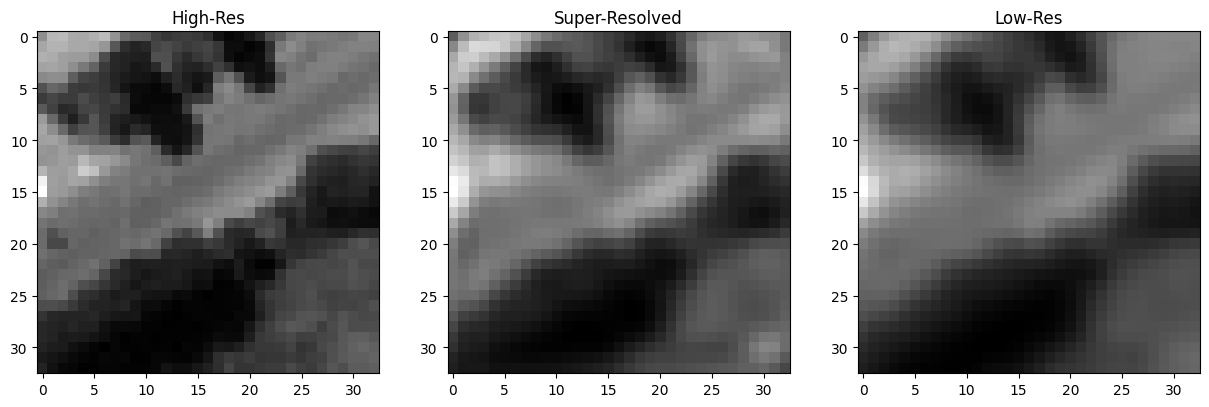

In [2]:
import numpy as np
import scipy.io as sio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


## ==================== DATA PROCESSING ==================== ##

def load_and_mirror(filename):
    """Load PaviaU data with mirror padding"""
    mat_data = sio.loadmat(filename)
    
    # Find the data key (common keys: 'paviaU', 'data', 'img')
    data_key = [k for k in mat_data.keys() if not k.startswith('__')][0]
    data = mat_data[data_key]
    
    # Mirror padding (4 bands on each side)
    left_pad = data[:, :, :4][:, :, ::-1]  # First 4 bands mirrored
    right_pad = data[:, :, -4:][:, :, ::-1] # Last 4 bands mirrored
    mirrored = np.concatenate([left_pad, data, right_pad], axis=2)
    
    # Normalize to [0, 1]
    return (mirrored - mirrored.min()) / (mirrored.max() - mirrored.min())

def gaussian_downsample(data, scale=2):
    """Fixed Gaussian downsampling that maintains dimensions"""
    k = 2.7725887 / (scale ** 2)
    h, w, c = data.shape
    
    # Create Gaussian kernel
    kernel_size = scale * 2 + 1
    x = np.linspace(-scale, scale, kernel_size)
    kernel = np.exp(-k * (x**2))
    kernel = np.outer(kernel, kernel)
    kernel /= np.sum(kernel)  # Normalize
    
    # Downsample each band with proper padding
    lr_data = np.zeros((h//scale, w//scale, c))
    kernel = kernel[..., np.newaxis, np.newaxis]  # Shape for conv2d
    
    for b in range(c):
        # Add padding to maintain dimensions after convolution
        padded = tf.pad(data[:, :, b][np.newaxis, ..., np.newaxis], 
                       [[0,0], [scale,scale], [scale,scale], [0,0]], 
                       mode='REFLECT')
        
        # Perform convolution
        convolved = tf.nn.conv2d(
            padded,
            kernel,
            strides=[1, scale, scale, 1],
            padding='VALID'
        )
        lr_data[:, :, b] = convolved.numpy().squeeze()
    
    return lr_data

def modcrop(img, scale):
    """Crop image to be divisible by scale"""
    h, w = img.shape[:2]
    return img[:h - h % scale, :w - w % scale]

def generate_train_test(data, scale=2, test_size=0.2, patch_size=33, stride=14):
    """Generate aligned patches"""
    data = modcrop(data, scale)
    lr_data = gaussian_downsample(data, scale)
    
    # Resize to match HR dimensions
    lr_resized = tf.image.resize(lr_data, (data.shape[0], data.shape[1])).numpy()
    
    # Extract patches from same locations
    def _extract_patches(img):
        patches = []
        for i in range(0, img.shape[0]-patch_size+1, stride):
            for j in range(0, img.shape[1]-patch_size+1, stride):
                patches.append(img[i:i+patch_size, j:j+patch_size])
        return np.array(patches)
    
    hr_patches = _extract_patches(data)
    lr_patches = _extract_patches(lr_resized)
    
    # Split train/test
    split = int(len(hr_patches)*(1-test_size))
    return (lr_patches[:split], hr_patches[:split]), (lr_patches[split:], hr_patches[split:])

# Fix 2: Optimized model
def build_srcnn_3d():
    model = Sequential([
        tf.keras.layers.Input(shape=(33, 33, 111, 1)),  # Fixed input
        Conv3D(64, (9, 9, 7), activation='relu', padding='same'),
        Conv3D(32, (1, 1, 1), activation='relu', padding='same'),
        Conv3D(9, (1, 1, 1), activation='relu', padding='same'),
        Conv3D(1, (5, 5, 3), padding='same')
    ])
    model.compile(Adam(learning_rate=0.0005), loss='mse')  # Increased LR
    return model

    

## ==================== MAIN EXECUTION ==================== ##

if __name__ == '__main__':
    # 1. Load and preprocess data
    print("Loading and preprocessing data...")
    data = load_and_mirror('/kaggle/input/hyperspectral/PaviaU.mat/PaviaU.mat')
    print(f"Data shape: {data.shape}")  # Should be (610, 340, 111)
    
    # 2. Generate training and test data
    # 2. Generate training and test data
    print("Generating training patches...")
    train_data, test_data = generate_train_test(data)
    print(f"Train LR shape: {train_data[0].shape}")
    print(f"Train HR shape: {train_data[1].shape}")
    print(f"Number of training LR patches: {len(train_data[0])}")  # Added line
    print(f"Number of training HR patches: {len(train_data[1])}")  # Added line
    print(f"Number of test LR patches: {len(test_data[0])}")      # Added line
    print(f"Number of test HR patches: {len(test_data[1])}")      # Added line
    # You could also add a print statement about the patch size and stride used
    print(f"Patch size: {33}, Stride: {14}") # Assuming default values
    print("Training and test patch generation complete.")
    
    # 3. Train model
    print("Training model...")
    # 3. Train model
    print("Training model...")
    model = build_srcnn_3d()
    print("\nModel Architecture:")  # Added line
    model.summary()                  # Added line
    print(f"\nOptimizer: {model.optimizer.get_config()['name']}") # Added line
    print(f"Learning Rate: {model.optimizer.get_config()['learning_rate']}") # Added line
    print(f"Loss Function: {model.loss}")        # Added line
    print(f"Batch Size: {64}")                   # Assuming default value
    print(f"Number of Epochs: {50}")             # Assuming default value
    
    # Add channel dimension
    train_lr = train_data[0].astype('float32')[..., np.newaxis]
    train_hr = train_data[1].astype('float32')[..., np.newaxis]
    print(f"\nTraining data shape (LR with channel): {train_lr.shape}") # Added line
    print(f"Training data shape (HR with channel): {train_hr.shape}") # Added line
    print("Note: The last dimension represents the channel (spectral band). Hyperspectral data has high dimensionality.") # Added line
    
    history = model.fit(
        train_lr,
        train_hr,
        batch_size=64,
        epochs=50,  # Reduced for testing
        validation_split=0.1,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) ], 
    )
    
    model.save('/kaggle/working/srcnn_pavia.h5')
    
    # 4. Evaluate
    print("Evaluating...")
    test_pred = model.predict(test_data[0][..., np.newaxis])
    
    # Calculate PSNR
def calculate_psnr(y_true, y_pred):
    """Calculate PSNR for 3D hyperspectral data"""
    mse = np.mean((y_true - y_pred) ** 2)
    return 10 * np.log10(1.0 / mse)

# Evaluation
print("Evaluating...")
try:
    # Process first sample only for simplicity
    test_pred = model.predict(test_data[0][:1][..., np.newaxis])  # Add channel dim
    
    # Calculate PSNR (remove extra dimensions)
    psnr = calculate_psnr(test_data[1][0], test_pred[0,...,0]) 
    print(f"PSNR: {psnr:.2f} dB")
    
    # Visual comparison (middle band)
    band_idx = 50
    plt.figure(figsize=(15, 5))
    plt.subplot(131).imshow(test_data[1][0, :, :, band_idx], cmap='gray')
    plt.title('High-Res')
    plt.subplot(132).imshow(test_pred[0, :, :, band_idx, 0], cmap='gray')
    plt.title('Super-Resolved')
    plt.subplot(133).imshow(test_data[0][0, :, :, band_idx], cmap='gray')
    plt.title('Low-Res')
    plt.show()

except Exception as e:
    print(f"Evaluation failed: {str(e)}")

Showing random test samples...

Sample 1 (Index 38) PSNR: 23.64 dB


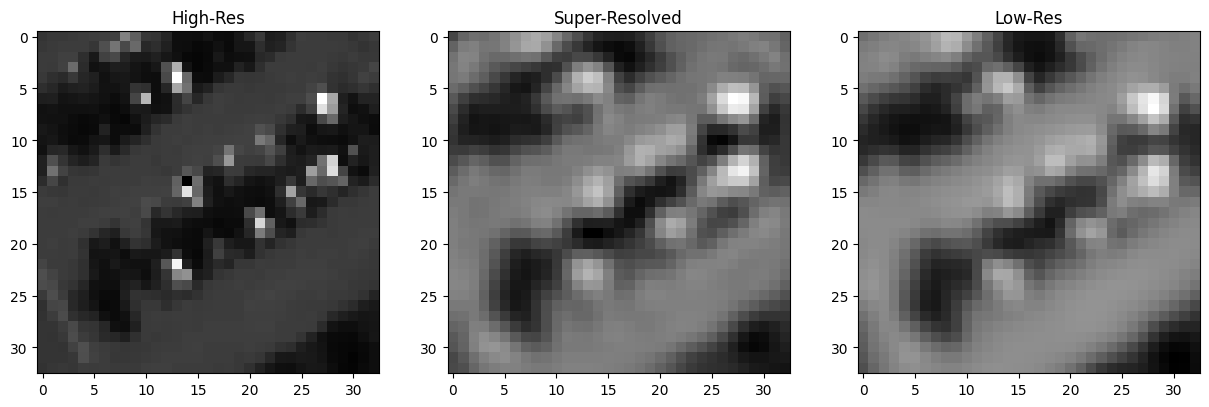


Sample 2 (Index 163) PSNR: 35.59 dB


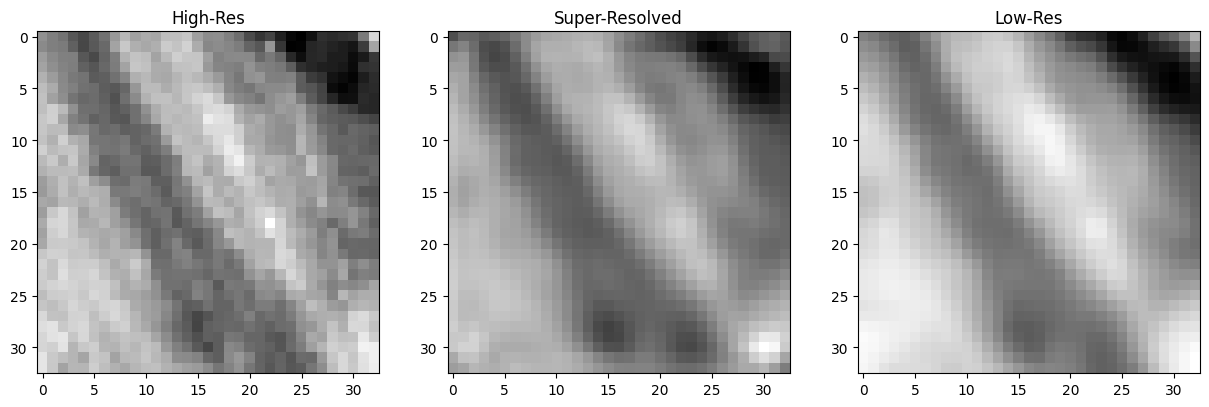


Sample 3 (Index 24) PSNR: 30.26 dB


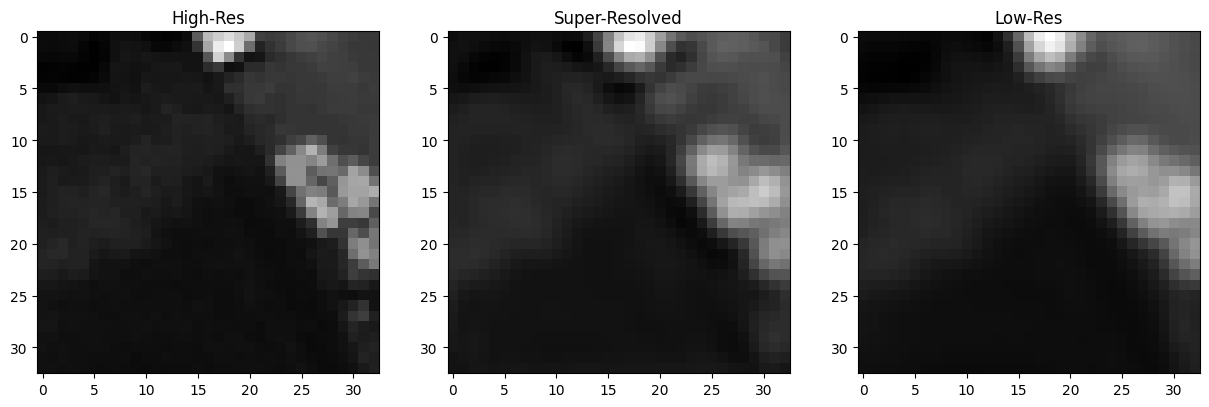

In [3]:
def show_random_samples(model, test_data, num_samples=3):
    """Show PSNR and visualization for random test samples"""
    # Get random indices
    num_total = len(test_data[0])
    sample_indices = np.random.choice(num_total, min(num_samples, num_total), replace=False)
    
    for i, idx in enumerate(sample_indices):
        # Get test pair
        lr_patch = test_data[0][idx][np.newaxis, ..., np.newaxis]  # Add batch and channel dim
        hr_patch = test_data[1][idx]
        
        # Predict
        pred = model.predict(lr_patch, verbose=0)
        
        # Calculate PSNR
        psnr = calculate_psnr(hr_patch, pred[0, ..., 0])  # Remove batch/channel dims
        print(f"\nSample {i+1} (Index {idx}) PSNR: {psnr:.2f} dB")
        
        # Show middle band (band 50)
        band_idx = 50
        plt.figure(figsize=(15, 5))
        plt.subplot(131).imshow(hr_patch[..., band_idx], cmap='gray')
        plt.title('High-Res')
        plt.subplot(132).imshow(pred[0, ..., band_idx, 0], cmap='gray')
        plt.title('Super-Resolved')
        plt.subplot(133).imshow(test_data[0][idx, ..., band_idx], cmap='gray')
        plt.title('Low-Res')
        plt.show()

# Usage
print("Showing random test samples...")
show_random_samples(model, test_data, num_samples=3)  # Change 3 to how many you want

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def explore_results(model, test_data):
    """Interactive exploration of test results"""
    num_samples = len(test_data[0])
    
    @interact(
        sample_idx=IntSlider(min=0, max=num_samples-1, step=1, value=0, description='Sample #'),
        band_idx=IntSlider(min=0, max=110, step=1, value=50, description='Band #'),
        display_psnr=True
    )
    def show_sample(sample_idx, band_idx, display_psnr):
        # Get test pair
        lr_patch = test_data[0][sample_idx][np.newaxis, ..., np.newaxis]
        hr_patch = test_data[1][sample_idx]
        
        # Predict
        pred = model.predict(lr_patch, verbose=0)[0,...,0]  # Remove batch/channel dims
        
        # Calculate PSNR if requested
        if display_psnr:
            psnr = calculate_psnr(hr_patch, pred)
            print(f"PSNR: {psnr:.2f} dB")
        
        # Visualization
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
        
        ax1.imshow(hr_patch[..., band_idx], cmap='gray')
        ax1.set_title('High-Res')
        ax1.axis('off')
        
        ax2.imshow(pred[..., band_idx], cmap='gray')
        ax2.set_title('Super-Resolved')
        ax2.axis('off')
        
        ax3.imshow(test_data[0][sample_idx, ..., band_idx], cmap='gray')
        ax3.set_title('Low-Res')
        ax3.axis('off')
        
        plt.tight_layout()
        plt.show()

# Usage
print("Interactive exploration - use the sliders below!")
explore_results(model, test_data)

Interactive exploration - use the sliders below!


interactive(children=(IntSlider(value=0, description='Sample #', max=184), IntSlider(value=50, description='Ba…

In [6]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(y_true, y_pred, multichannel=True):
    """Calculate SSIM for 3D hyperspectral data"""
    ssim_values = []
    for b in range(y_true.shape[-1]):  # Loop through bands
        ssim_values.append(ssim(y_true[...,b], y_pred[...,b], 
                              data_range=1.0,  # For normalized [0,1] data
                              multichannel=False))
    return np.mean(ssim_values)

# Usage
ssim_score = calculate_ssim(test_data[1][0], test_pred[0,...,0])
print(f"SSIM: {ssim_score:.4f}")

SSIM: 0.9292


In [7]:
def calculate_sam(y_true, y_pred):
    """Spectral angle mapper for hyperspectral data"""
    numerator = np.sum(y_true * y_pred, axis=-1)
    denominator = np.linalg.norm(y_true, axis=-1) * np.linalg.norm(y_pred, axis=-1)
    sam = np.mean(np.arccos(numerator / denominator))
    return np.degrees(sam)  # Convert to degrees

# Usage
sam_angle = calculate_sam(test_data[1][0], test_pred[0,...,0])
print(f"SAM: {sam_angle:.2f}°")

SAM: 5.25°


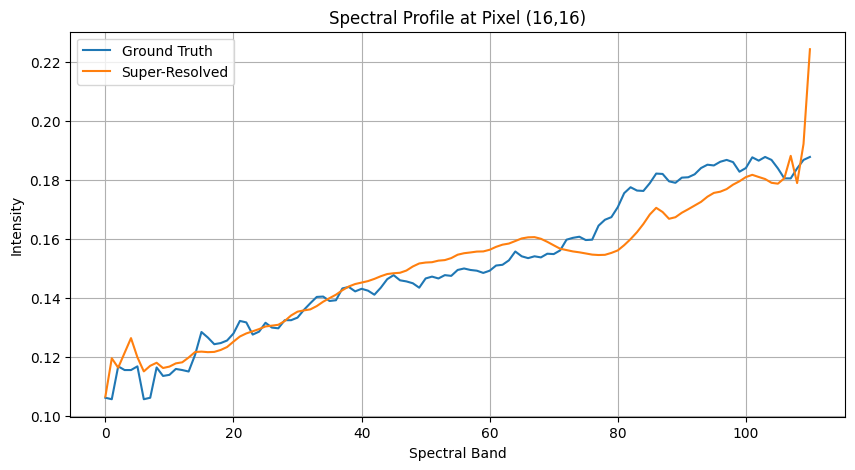

In [8]:
def plot_spectral_profile(y_true, y_pred, pixel_x=16, pixel_y=16):
    """Compare spectral signatures at specific pixel"""
    plt.figure(figsize=(10, 5))
    plt.plot(y_true[pixel_x, pixel_y, :], label='Ground Truth')
    plt.plot(y_pred[pixel_x, pixel_y, :], label='Super-Resolved')
    plt.xlabel('Spectral Band')
    plt.ylabel('Intensity')
    plt.title(f'Spectral Profile at Pixel ({pixel_x},{pixel_y})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage
plot_spectral_profile(test_data[1][0], test_pred[0,...,0])

In [9]:
def evaluate_all(model, test_data, num_samples=10):
    """Calculate all metrics for multiple samples"""
    results = {'PSNR': [], 'SSIM': [], 'SAM': []}
    
    for i in range(min(num_samples, len(test_data[0]))):
        pred = model.predict(test_data[0][i][np.newaxis,...,np.newaxis])[0,...,0]
        hr = test_data[1][i]
        
        results['PSNR'].append(calculate_psnr(hr, pred))
        results['SSIM'].append(calculate_ssim(hr, pred))
        results['SAM'].append(calculate_sam(hr, pred))
    
    print("\nAverage Metrics:")
    for metric, values in results.items():
        print(f"{metric}: {np.mean(values):.2f} (±{np.std(values):.2f})")

# Usage
evaluate_all(model, test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Average Metrics:
PSNR: 32.33 (±1.45)
SSIM: 0.91 (±0.01)
SAM: 4.57 (±0.69)


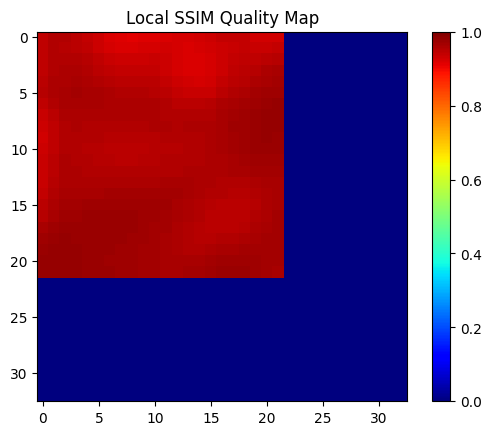

In [10]:
def quality_map(y_true, y_pred, band_idx=50, window_size=11):
    """Local SSIM quality map"""
    ssim_map = np.zeros_like(y_true[...,0])
    for i in range(y_true.shape[0]-window_size):
        for j in range(y_true.shape[1]-window_size):
            patch_true = y_true[i:i+window_size,j:j+window_size,band_idx]
            patch_pred = y_pred[i:i+window_size,j:j+window_size,band_idx]
            ssim_map[i,j] = ssim(patch_true, patch_pred, data_range=1.0)
    
    plt.imshow(ssim_map, cmap='jet', vmin=0, vmax=1)
    plt.colorbar()
    plt.title('Local SSIM Quality Map')
    plt.show()

# Usage
quality_map(test_data[1][0], test_pred[0,...,0])

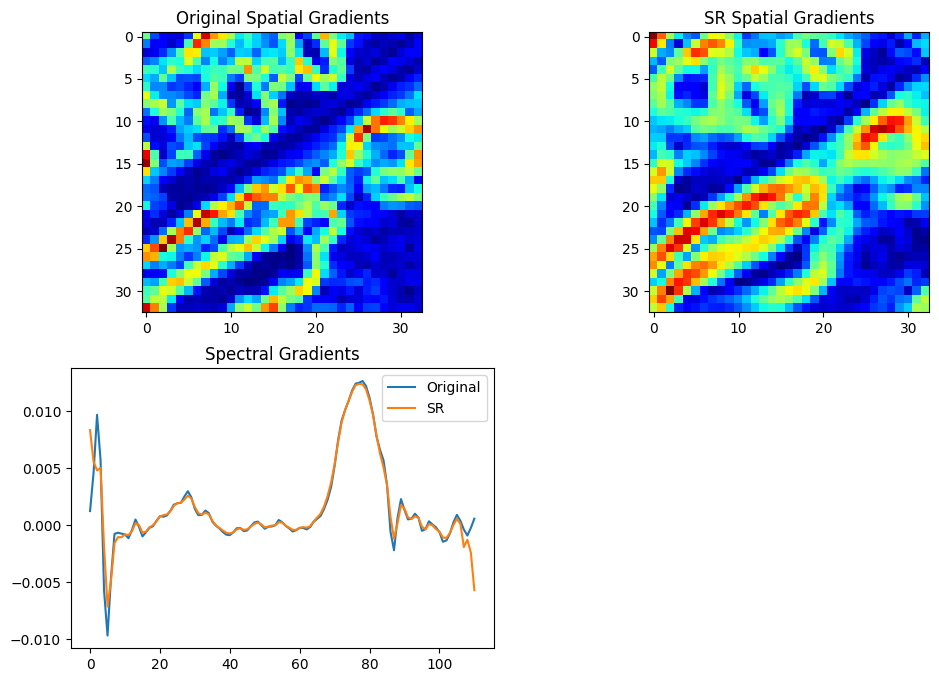

In [11]:
def spatial_spectral_gradients(data):
    """Analyze spatial and spectral gradients"""
    # Spatial gradients
    dx = np.gradient(data, axis=0)
    dy = np.gradient(data, axis=1)
    spatial_grad = np.mean(np.sqrt(dx**2 + dy**2), axis=-1)
    
    # Spectral gradients
    spectral_grad = np.mean(np.gradient(data, axis=2), axis=(0,1))
    
    return spatial_grad, spectral_grad

# Compare gradients
sp_gt, spec_gt = spatial_spectral_gradients(test_data[1][0])
sp_sr, spec_sr = spatial_spectral_gradients(test_pred[0,...,0])

plt.figure(figsize=(12,8))
plt.subplot(221).imshow(sp_gt, cmap='jet')
plt.title('Original Spatial Gradients')
plt.subplot(222).imshow(sp_sr, cmap='jet')
plt.title('SR Spatial Gradients')
plt.subplot(223).plot(spec_gt, label='Original')
plt.plot(spec_sr, label='SR')
plt.title('Spectral Gradients')
plt.legend()
plt.show()